<a href="https://colab.research.google.com/github/daksha200/CollegeProject/blob/testrepo/Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

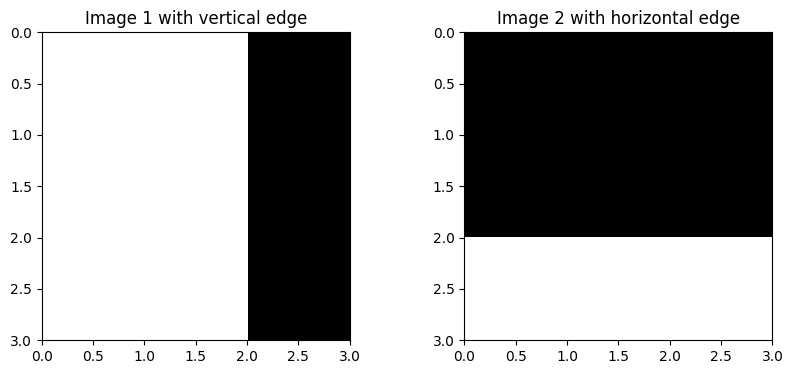

In [30]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0],
                   [1,1,0],
                   [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0],
                   [0,0,0],
                   [1,1,1]])

# print(image1*255)
# Let's plot the images
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
# plt.ylim(0, 3)
ax.set_title('Image 1 with vertical edge')

ax = fig.add_subplot(1,2,2)
ax.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
ax.set_title('Image 2 with horizontal edge')
plt.show()

Let's create a 3x3 vertical edge filter. We will 'convolve' this filter over the images to detect vertical edge. As the image is same size as of filter, this is simple element-wise multiplication and summing up the result into single value.

In [31]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

In [32]:
# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Now, let's create a horizontal edge filter and apply it to both the above images.

In [33]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)


Output from first image:  0
Output from second image:  3


As expected, the horizontal edge is detected in second image with this filter.

Now, we will take a bigger image (5 x 5) and see how a convolution operation works by sliding a filter left to right and top to bottom to obtain an output map from image. Let's define a function apply_filter() for this.

In [34]:
def apply_filter(img, filter):
  height, width = img.shape
  filter_size = filter.shape

  output = np.empty(0)

  # Move the filter over entire image and store the result in output
  for i in range(0, height - filter_size[1] + 1):
    for j in range(0, width - filter_size[0] + 1):
      # Matrix multiplication for a single patch of image and filter
      output = np.append(output, np.sum(np.multiply(img[i:i+filter_size[0], j:j+filter_size[1]], filter)))

  # Calculate the output shape of the resultant image
  output_shape = (height - (filter_size[1]-1)), (width - (filter_size[0]-1))

  # Return the reshaped image
  return output.reshape(output_shape)

Plotting function

In [35]:
def plot_images(images, titles, tick_params=True):
  n = len(images)
  fig = plt.figure(figsize=(10,4))
  for i in range(n):
    ax = fig.add_subplot(1,n,i+1)
    if len(images[i].shape) == 2:
      ax.imshow(images[i], cmap='gray',
                extent=(0,images[i].shape[1], images[i].shape[0], 0))
    else:
      ax.imshow(images[i])
    ax.set_title(titles[i])
    if not tick_params:
      plt.tick_params(axis='both', labelbottom=False, bottom=False,
                labelleft=False, left=False)
  plt.show()

In [36]:
# 2D image
img = np.array([[20,20,0,0,0],
                [20,20,0,0,0],
                [20,20,0,0,0],
                [20,20,0,0,0],
                [20,20,0,0,0]])

# Vertical edge filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])


output = apply_filter(img, filter)
print(output) # Note the shape of output image!

[[60. 60.  0.]
 [60. 60.  0.]
 [60. 60.  0.]]


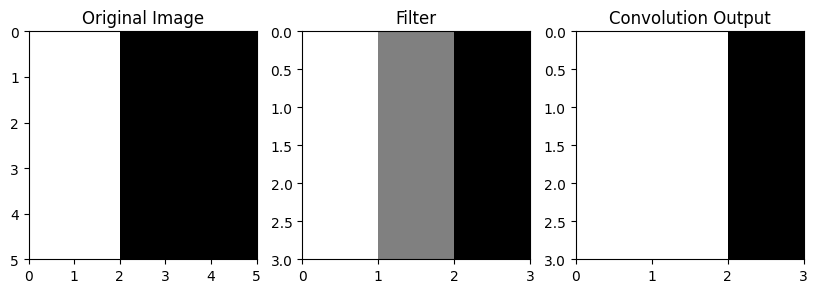

In [37]:
# Let's plot the above image with results
images = []
titles = []

images.append(img)
titles.append('Original Image')

images.append(filter)
titles.append('Filter')

images.append(output)
titles.append('Convolution Output')

plot_images(images, titles)

As, you can see, horizontal edge is detected in the output.

Now, we will see the effect of applying this filter on a grayscale image. Again, for this, we need to 'convolve' the filter over the entire image. We will use the same filter and function defined earlier.

In [38]:
# Read the image with opencv, 0 stands for 'grayscale'
image = cv2.imread('/content/sample_data/panda.jpg', 0)
print('Original image size: ', image.shape)

# Saving images for plots
images = []
titles = []

images.append(image)
titles.append('Original Image')

# Vertical edge filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

images.append(filter)
titles.append('Filter')

# Apply this filter to image
output = apply_filter(image, filter)

print('Output image size: ', output.shape)

images.append(output)
titles.append('Convolution Output')


Original image size:  (360, 534)
Output image size:  (358, 532)


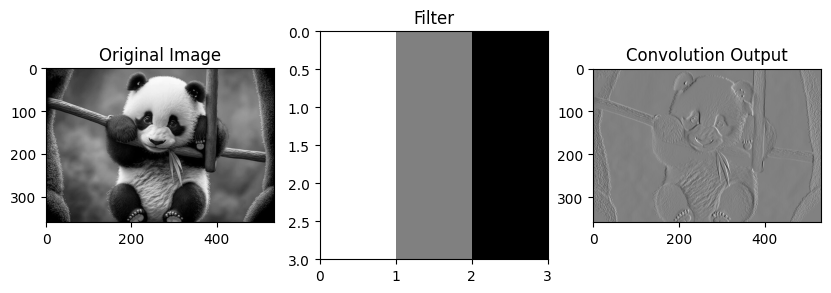

In [39]:
# Let's plot the images
plot_images(images, titles)


In [40]:
# Import pytorch packages
import torch
from torch.nn import Conv2d

We will define a helper function to create an square vertical edge filter of given size

In [41]:
def generate_filter(k=3):
  kernel = np.ones((k, k))
  mid_index = k // 2
  kernel[:, mid_index].fill(0)
  kernel[:, mid_index+1:] *= -1
  return kernel

We will create a helper function that takes one of the kernel elements, create a Convolution layer using pytorch and return the output image

In [42]:
def apply_conv(image, kernel_size, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  # Convert image to tensor from numpy
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  # Create a nxn kernel
  kernel = generate_filter(kernel_size)

  # Create a tensor from the numpy array
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))
  # ---------CONVOLUTION LAYER--------
  #1 input image channel, 1 output channels, nxn square convolution with padding on all 4 sides
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input / 255.)  # Getting input from 0 to 1
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img


**Effect of Padding**
Change the padding value with the slider.

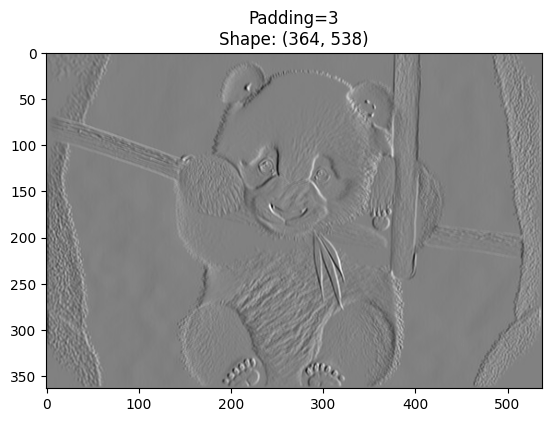

In [43]:
# Apply 3x3 convolution to image with given padding 1 on all 4 sides
padding = 3 #@param {type:"slider", min:1, max:20, step:1}
n = apply_conv(image, 3, padding=padding)

# Plot the results
plt.imshow(n, cmap='gray')
plt.title('Padding={}\nShape: {}'.format(padding, str(n.shape)))
plt.show()



As you observed, the output shape changes with padding. More the padding, bigger will be the image.

**Effect of Kernel size**
Change the kernel size with the slider

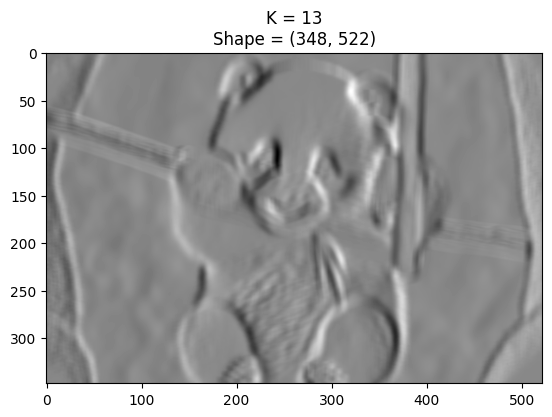

In [44]:
#@title Effect of Kernel size { run: "auto", vertical-output: true, display-mode: "both" }
# Apply 3x3 convolution to image
K = 13 #@param {type:"slider", min:3, max:21, step:2}
n = apply_conv(image, K)

# Plot result
plt.imshow(n, cmap='gray')
plt.title('K = {}\nShape = {}'.format(K, str(n.shape)))
plt.show()

Thus, we conclude that output image becomes blurry with increase in kernel size as summation occurs over larger neighbourhood. Smaller kernel size is used to capture details whereas larger kernel captures bigger elements in image.

**Effect of Stride**
Change the stride value with the slider

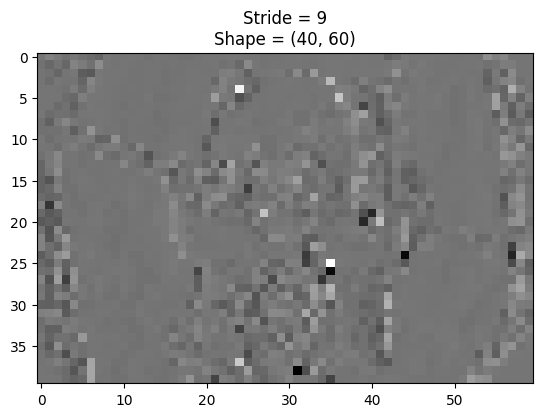

In [45]:
#@title Effect of Stride { run: "auto", vertical-output: true, display-mode: "both" }
# Apply 3x3 convolution to image
stride = 9 #@param {type:"slider", min:1, max:10, step:1}
n = apply_conv(image, 3, stride=stride)

# Plot result
plt.imshow(n, cmap='gray')
plt.title('Stride = {}\nShape = {}'.format(stride, str(n.shape)))
plt.show()

As we can see, the output becomes pixelated as strides increase because we have fewer values in the output by skipping pixels in input.

**Hence size of output decreases.**